# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.
Постройте модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте accuracy на тестовой выборке самостоятельно.


**Описание данных**
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Откройте и изучите файл

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from tqdm import tqdm
from sklearn.dummy import DummyClassifier

In [2]:
data = pd.read_csv('/datasets/users_behavior.csv') #прочитаем csv-файл

In [3]:
data.shape #посмотрим количество строк и стоблцо

(3214, 5)

In [4]:
data.head() #посмотрим первые 5 строк

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [5]:
data.info() #посмотрим информацию о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [6]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Пропущенные значения отсутствуют, тип данных менять не требуется.

## Разбейте данные на выборки

Разобъем данные на 3 части: обучающую, валидационную и тестовую (60%, 20% и 20%).

In [7]:
features = data.drop(['is_ultra'], axis=1)
target = data['is_ultra']

In [8]:
features_train, features_test, target_train, target_test = \
train_test_split(features, target, test_size = 0.4, random_state=12345, stratify = target) #тестовая выборка

In [9]:
features_test, features_valid, target_test, target_valid = \
train_test_split(features_test, target_test, test_size = 0.5, random_state=12345, stratify = target_test) #валидационная выборка

Посмотрим размеры выборок

In [10]:
features_train.shape, target_train.shape

((1928, 4), (1928,))

In [11]:
features_test.shape, target_test.shape

((643, 4), (643,))

In [12]:
features_valid.shape, target_valid.shape

((643, 4), (643,))

Поделили данные на 3 части: обучающую, тестовую и валидационную (60%, 20% и 20%).
Каждую выборку поделили на признаки и целевые признаки, в нашем случае тариф.

## Исследуйте модели

**Дерево решений**

In [13]:
best_model_dtc = None
best_result_dtc = 0
for depth in range(1, 30):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions)
    if result > best_result_dtc:
        best_model_dtc = model
        best_result_dtc = result
print("Доля правильных ответов модели дерева решений на валидационной выборке:", best_result_dtc.round(3))       

Доля правильных ответов модели дерева решений на валидационной выборке: 0.812


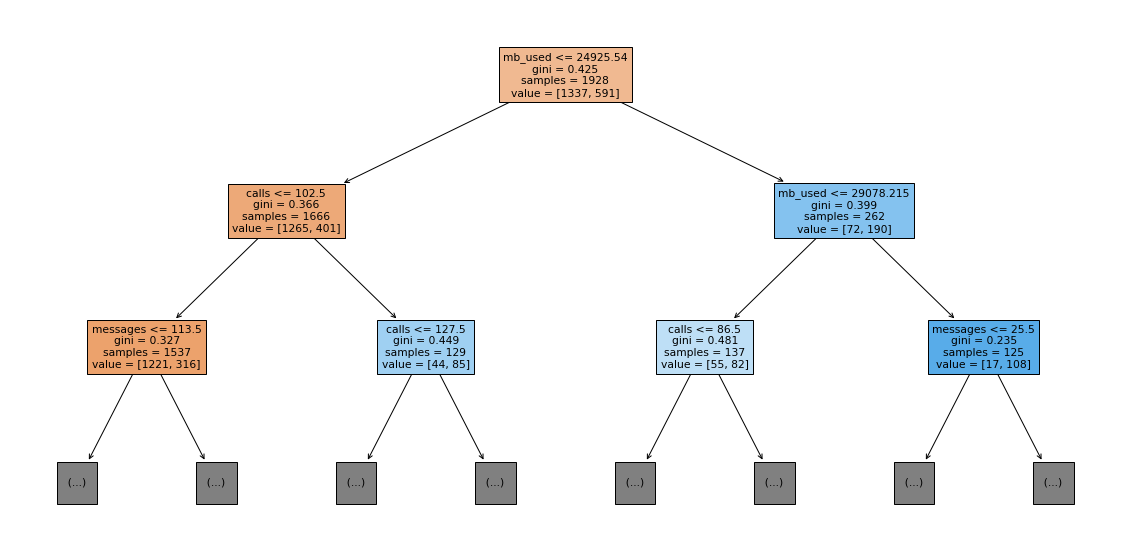

In [14]:
plt.figure(figsize=(20, 10))
plot_tree(best_model_dtc, feature_names=features_train.columns, filled = True, max_depth=2)
plt.title('')
plt.show() #построим первые ветки

**Случайный лес**

In [15]:
best_model_rfc = None
best_result_rfc = 0
for n_estimators in tqdm(range(3,58)):
    for depth in range(1, 30):
        model = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth=depth)
        model.fit(features_train, target_train)
        result = model.score(features_valid, target_valid)
        if result > best_result_rfc:
            best_model_rfc = model
            best_result_rfc = result
print("Доля правильных ответов модели случайный лес на валидационной выборке:", best_result_rfc.round(3))        

100%|██████████| 55/55 [02:02<00:00,  2.22s/it]

Доля правильных ответов модели случайный лес на валидационной выборке: 0.821


***Рассмотрели модели дерево решений и случайный лес. <br>
Первая показала результат 0,812, вторая показала лучший результат 0,821.***

## Проверьте модель на тестовой выборке

**Дерево решений**

In [16]:
prediction_dtc = best_model_dtc.predict(features_test)
accuracy_dtc = accuracy_score(target_test, prediction_dtc).round(3)
print("Доля правильных ответов модели дерево решений на тестовой выборке:", accuracy_dtc)

Доля правильных ответов модели дерево решений на тестовой выборке: 0.785


**Случайный лес**

In [17]:
prediction_rfc = best_model_rfc.predict(features_test)
accuracy_rfc = accuracy_score(target_test, prediction_rfc).round(3)
print("Доля правильных ответов модели случайный лес на тестовой выборке:", accuracy_rfc)       

Доля правильных ответов модели случайный лес на тестовой выборке: 0.801


**На тестовой выборке точность предсказания моделей дерево решений 0,785 и случайный лес 0,801.**

----

***Обучим модель на объединенных тренировочной и валидационной выборках***

In [18]:
features_train_valid = pd.concat((features_train, features_valid), axis=0)
target_train_valid = pd.concat((target_train, target_valid), axis=0)
features_train_valid.shape, target_train_valid.shape #посмотрим размер объединенной выборки

((2571, 4), (2571,))

In [19]:
best_model_rfc.fit(features_train_valid, target_train_valid)
prediction_rfc = best_model_rfc.predict(features_test)
accuracy_rfc = accuracy_score(target_test, prediction_rfc).round(3)
print("Доля правильных ответов на объединенной выбоке модели случайный лес на тестовой выборке:", accuracy_rfc) 

Доля правильных ответов на объединенной выбоке модели случайный лес на тестовой выборке: 0.83


## (бонус) Проверьте модели на адекватность

In [20]:
dummy_clf = DummyClassifier(strategy = 'most_frequent',random_state = 12345)
dummy_clf.fit(features_train, target_train)
prediction_dummy_test = dummy_clf.predict(features_test)
print('Адекватность модели', accuracy_score(target_test,prediction_dummy_test).round(3))

Адекватность модели 0.694


<div class="alert-info" style="padding: 20px; border-radius: 10px"> 
<b>Вывод</b>
    
  
Предобработка данных была выполнена.
    
Разбили данные на 3 выборки: обучающую 60%, валидационную и тестовую (по 20% в каждой).
Каждую выборку поделили на признаки и целевые признаки, в нашем случае тариф.

Рассмотрели модели дерево решений и случайный лес.
<br>    
Результаты: 
- валидационная выборка: дерево решений 81%, случайный лес 82%
- тестовая выборка: дерево решений 76%, случайный лес 80%    

Предсказания модели случайный лес точнее.
Объединили обучающую и валидационную выборки, результат тестовой выборки возрос до 83%.  

Проверка наивной моедли на адекватность составила 0.694, модель случайный лес адекватна.
    
Удалось достичь accuracy не менее 0.75. <div>